In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils

In [2]:
noise_filter = True

In [3]:
# Read images
data_files = glob.glob("data/composite_data/2016*.npy")

if noise_filter:
    noise_imgs = []
    with open("manual_noise.txt", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    noise_imgs = [x.split("/")[-1].replace(".fits", ".npy") for x in noise_imgs]

    data_files = [f for f in data_files if f.split("/")[-1] not in noise_imgs]

# data_matrix = np.empty([len(data_files),256,256,3])
data_matrix = np.empty([len(data_files),204,204,3])

for idx, data_file in enumerate(data_files):
    data_point = np.load(data_file)
    # data_matrix[idx] = data_point[(center[0]-radius):(center[0]+radius), (center[1]-radius):(center[1]+radius)]
    data_matrix[idx] = data_point[26:230,26:230] # Precomputed limits to crop


data_matrix_old = data_matrix.copy()

data_matrix_norm = dg.MultiChannelAEGenerator.normalize(data_matrix)

# data_matrix_norm[:,:,:,2] = dg.HMImGenerator.apply_filter(data_matrix_norm[:,:,:,2], 4, 2)

data_matrix_norm[np.isnan(data_matrix_old[:,:,:,2]), 2] = 0 

input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

utils.range_tuple(data_matrix_norm)

/home/eugeniolr/Documents/master/TFM/data_generator.py:189: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:190: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:198: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


(0.0, 1.0)

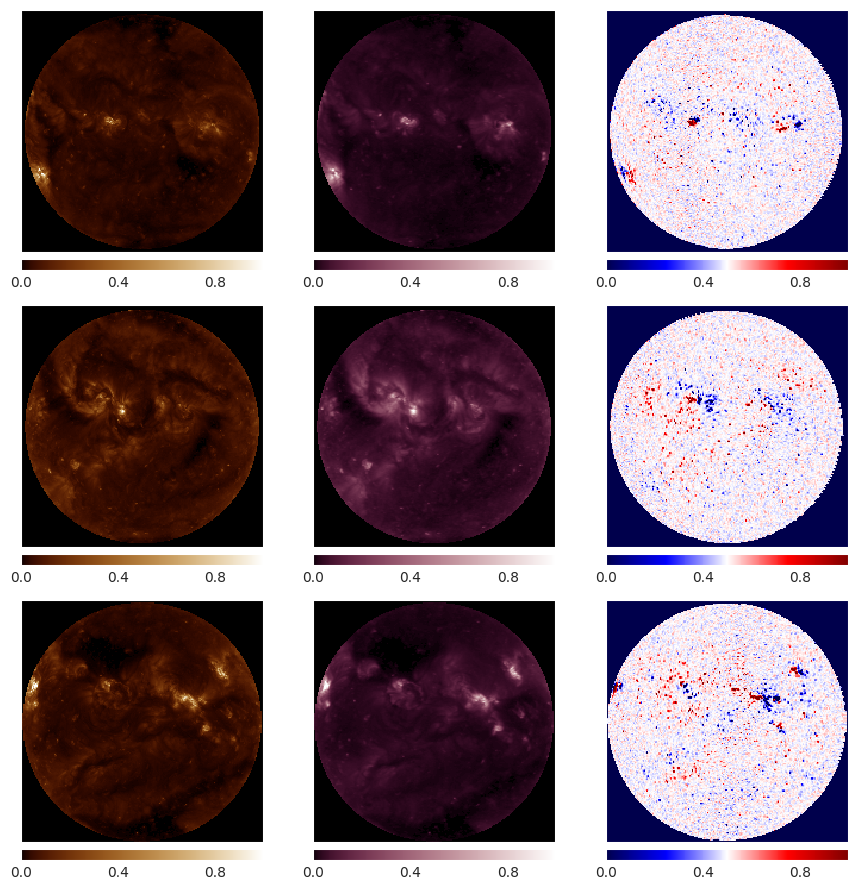

In [4]:
img_amount = 3

image_list = []
for data_image in data_matrix_norm[:img_amount]:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(
    image_list, 
    cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount,
    orientation="h",
    vmin=0, 
    vmax=1)

<AxesSubplot: >

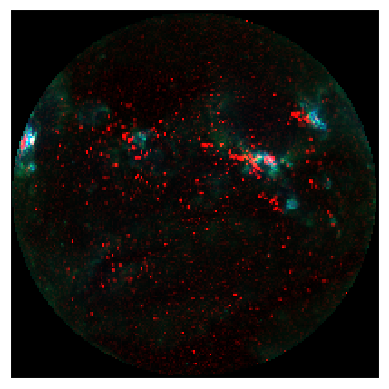

In [5]:
idx = 2

example = data_matrix_norm[idx].copy()
example[np.isnan(data_matrix_old[idx,:,:,2]), 2] = 0.5
example[:,:,2] = np.abs(2*example[:,:,2] - 1)
isns.imgplot(np.roll(example, axis=2, shift=1))

In [6]:
latent_size = 1024
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss_fn = "mse"

# autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)
autoencoder, encoder, decoder = aem.gen_xception_VAE_3c(latent_size, optim=optimizer, loss=loss_fn)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 204, 204, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 101, 101, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 101, 101, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [7]:
n_epochs = 500
batch_size = 16

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/500
104/104 [==============================] - 24s 151ms/step - loss: 21424.5332 - val_loss: 13637.2148
Epoch 2/500
104/104 [==============================] - 13s 129ms/step - loss: 12488.6895 - val_loss: 12849.2080
Epoch 3/500
104/104 [==============================] - 15s 140ms/step - loss: 11866.7119 - val_loss: 11465.0049
Epoch 4/500
104/104 [==============================] - 14s 134ms/step - loss: 11526.2568 - val_loss: 11495.8447
Epoch 5/500
104/104 [==============================] - 14s 134ms/step - loss: 11414.7441 - val_loss: 11517.7070
Epoch 6/500
104/104 [==============================] - 13s 129ms/step - loss: 11333.0352 - val_loss: 12053.1094
Epoch 7/500
104/104 [==============================] - 14s 132ms/step - loss: 11306.1855 - val_loss: 14572.5703
Epoch 8/500
104/104 [==============================] - 14s 135ms/step - loss: 11272.0400 - val_loss: 11536.4756
Epoch 9/500
104/104 [==============================] - 14s 132ms/step - loss: 11246.1807 - val_loss: 112

20/20 [==============================] - 1s 59ms/step - loss: 10924.4375


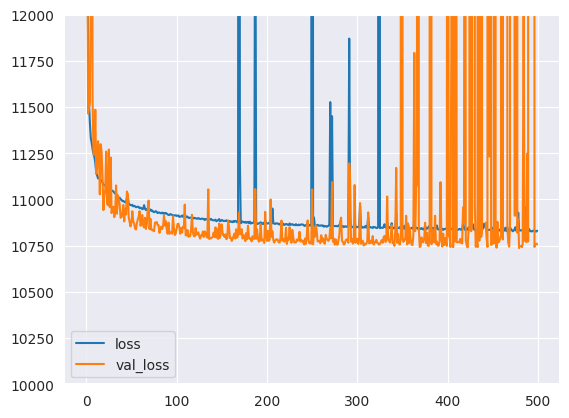

In [17]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.ylim(10000, 12000)
plt.show()

(1, 204, 204, 3)


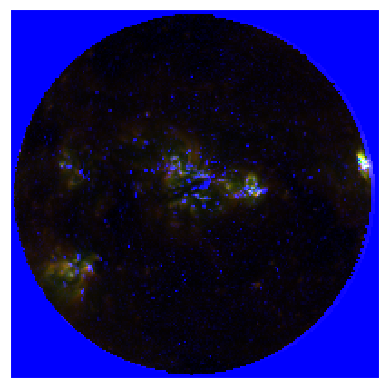

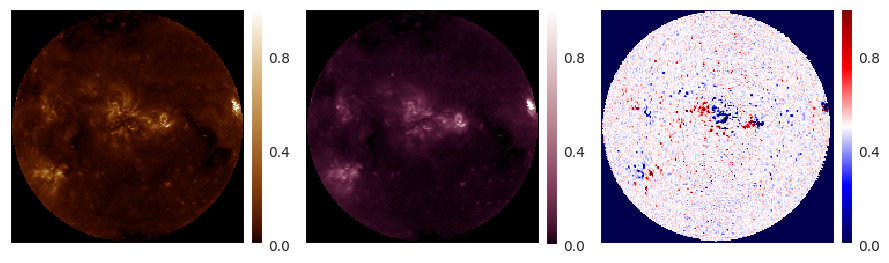

In [22]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)

test_img_display = test_img[0].copy()
test_img_display[:,:,2] = np.abs((0.5 - test_img_display[:,:,2])*2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

<AxesSubplot: >

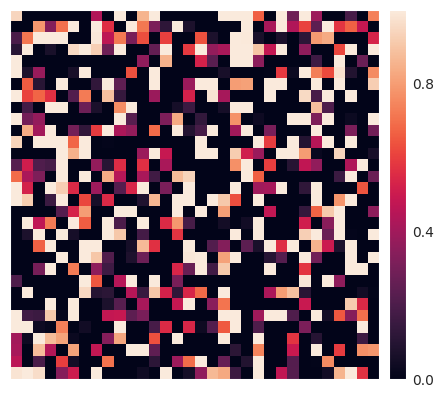

In [23]:
mean, var, code = encoder(test_img)

isns.imgplot(utils.square_dims_vector(np.asarray(code)), vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


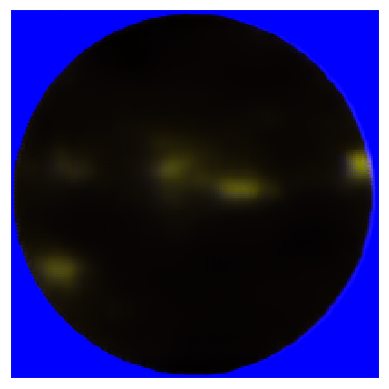

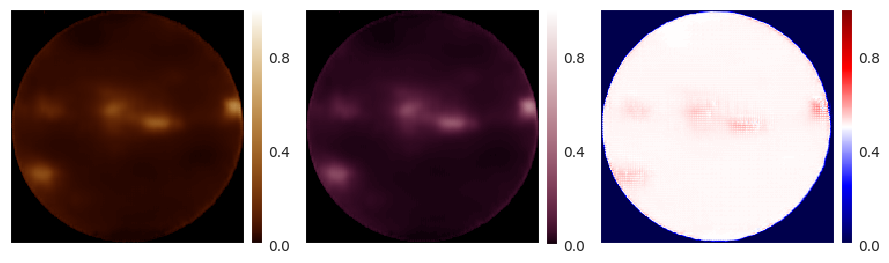

In [24]:
decoded = decoder(code)
# isns.imgplot(decoded[0])
decoded_display = np.copy(decoded[0])
decoded_display[:,:,2] = np.abs((0.5 - decoded_display[:,:,2])*2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

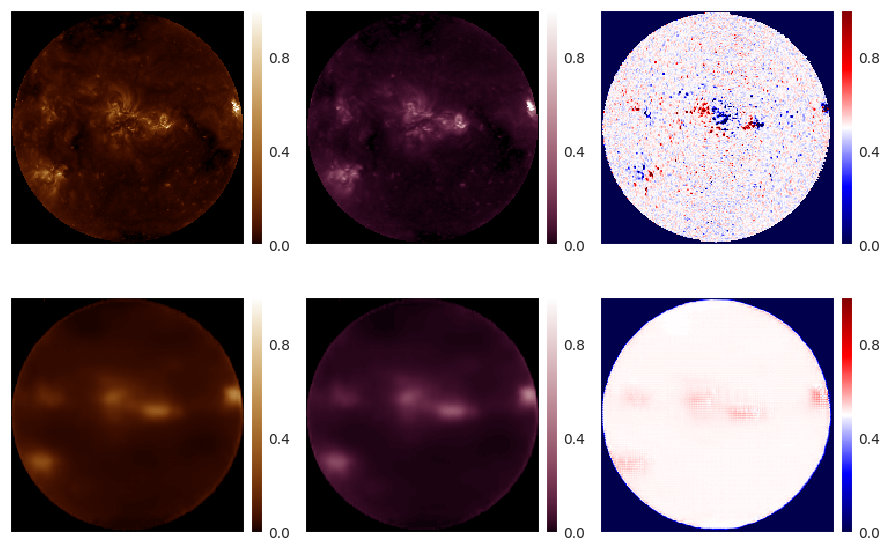

In [25]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=0, vmax=1)

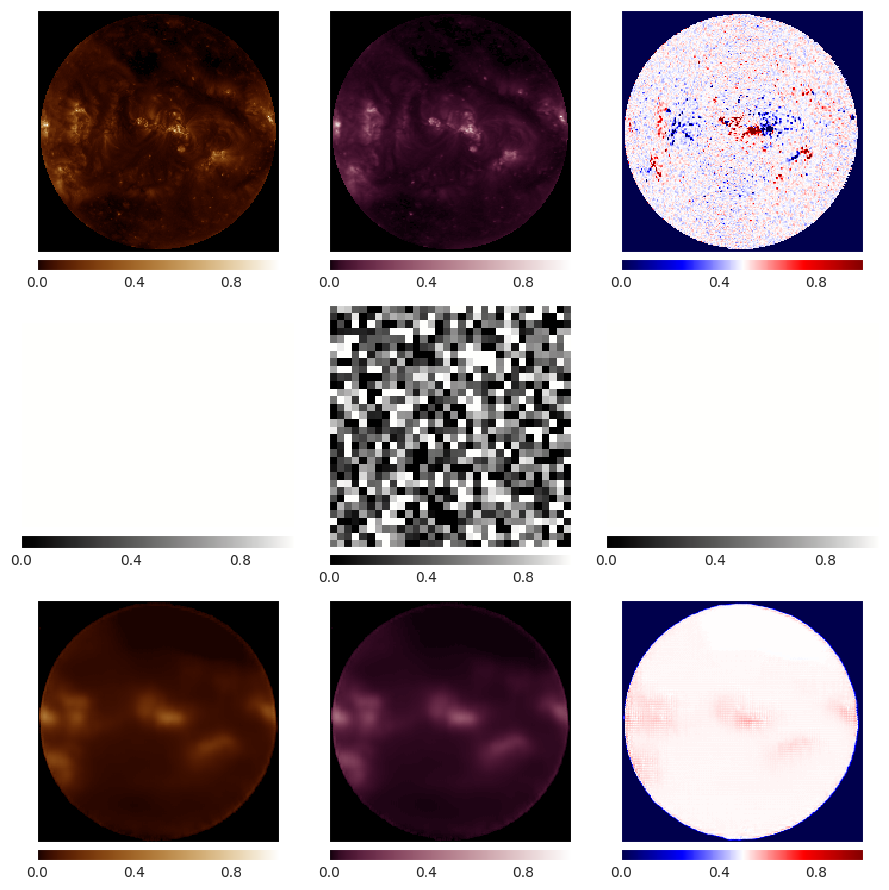

In [41]:
test_img = np.array(random.choices(input_test, k=1))
mean, var, code = encoder(test_img)
decoded = decoder(code)

test_img_channels = [i for i in test_img[0].transpose(2,0,1)]


code = (utils.square_dims_vector(np.asarray(code[0])) + 1)/2
code_img = [np.ones((3,4)), code, np.ones((3,4))]
                     
decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]

isns.ImageGrid(
    test_img_channels+code_img+decoded_img_channels,
    cmap=["sdoaia193", "sdoaia211", "seismic"] + ["gray"]*3 + ["sdoaia193", "sdoaia211", "seismic"],
    orientation="h",
    vmin=0, 
    vmax=1
)